In [2]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import sys
from pathlib import Path
GIT_ROOT = Path("../..").resolve()
SRC = GIT_ROOT / "src"
if not SRC in sys.path:
    sys.path.append(str(SRC))

In [8]:
from geometries import FlatFanBeamGeometry, DEVICE
from models.fbps import AdaptiiveFBP as AFBP
from models.FNOBPs.fnobp import FNO_BP
from models.modelbase import plot_model_progress
from statistics import mean
import matplotlib.pyplot as plt

ar = 0.5 #angle ratio
PHANTOM_DATA = torch.stack(torch.load("../../data/HTC2022/HTCTrainingPhantoms.pt")).to(DEVICE)

geometry = FlatFanBeamGeometry(720, 560, 410.66, 543.74, 112, [-40,40, -40, 40], [512, 512])
SINO_DATA = geometry.project_forward(PHANTOM_DATA)

model = AFBP(geometry)
# model = FNO_BP(geometry, hidden_layers=[40,40], modes=geometry.projection_size//2)

dataset = TensorDataset(SINO_DATA, PHANTOM_DATA)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

optimizer = torch.optim.Adam(model.parameters(), lr=3e-7)
mse_fn = lambda diff : torch.mean(diff**2)
n_epochs = 300
for epoch in range(n_epochs):
    batch_losses = []
    for sino_batch, phantom_batch in dataloader:
        optimizer.zero_grad()

        start_ind = torch.randint(0, geometry.n_projections, (1,)).item()
        la_sinos, known_beta_bool = geometry.zero_cropp_sinos(sino_batch, ar=ar, start_ind=start_ind) #known_beta_bool is True at angles where sinogram is meassured and false otherwise
        la_sinos = geometry.reflect_fill_sinos(la_sinos, known_beta_bool)
        la_sinos = geometry.rotate_sinos(la_sinos, -start_ind) #FNO needs known angles to be in the same region all the time

        filtered = model.get_extrapolated_filtered_sinos(la_sinos)
        filtered = geometry.rotate_sinos(filtered, start_ind) #rotate back
        gt_filtered = geometry.inverse_fourier_transform(geometry.fourier_transform(sino_batch*geometry.jacobian_det)*geometry.ram_lak_filter())
        loss_sino_domain = mse_fn(gt_filtered-filtered)

        recons = F.relu(geometry.project_backward(filtered/2)) #sinogram covers 360deg  - double coverage
        loss_recon_domain = mse_fn(phantom_batch - recons)

        loss = loss_recon_domain #+ loss_sino_domain
        loss.backward()
        optimizer.step()

        batch_losses.append(loss.cpu().item())
    
    print("Epoch:", epoch+1, "loss is:", mean(batch_losses))

Epoch: 1 loss is: 0.010461450965359996
Epoch: 2 loss is: 0.010485996641728617
Epoch: 3 loss is: 0.010534132168833329
Epoch: 4 loss is: 0.009974957234281445
Epoch: 5 loss is: 0.010548123513925084
Epoch: 6 loss is: 0.010851430842553687
Epoch: 7 loss is: 0.01057814576356217
Epoch: 8 loss is: 0.0103668442406499
Epoch: 9 loss is: 0.010893497048827916
Epoch: 10 loss is: 0.010126085149192358
Epoch: 11 loss is: 0.010267587963019036
Epoch: 12 loss is: 0.010130441741314087
Epoch: 13 loss is: 0.010187782422442114
Epoch: 14 loss is: 0.010179638015623244
Epoch: 15 loss is: 0.010675081850141243
Epoch: 16 loss is: 0.010239556459355485
Epoch: 17 loss is: 0.009803769475206373
Epoch: 18 loss is: 0.010346361227445136
Epoch: 19 loss is: 0.010984949910708641
Epoch: 20 loss is: 0.01036250749836056
Epoch: 21 loss is: 0.009636943081157463
Epoch: 22 loss is: 0.009752989632126091
Epoch: 23 loss is: 0.009920201006249943
Epoch: 24 loss is: 0.01064178635901371
Epoch: 25 loss is: 0.010295656187474075
Epoch: 26 loss

sinogram mse: tensor(23.2799, device='cuda:0')
filterd sinogram mse:  tensor(0.3974, device='cuda:0')
reconstruction mse:  tensor(0.0100, device='cuda:0', dtype=torch.float64)


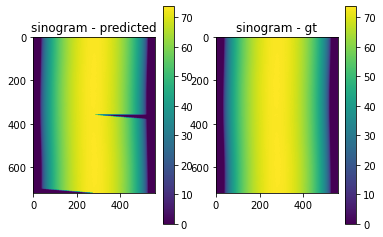

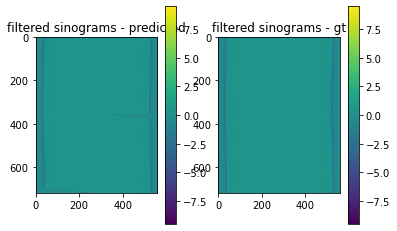

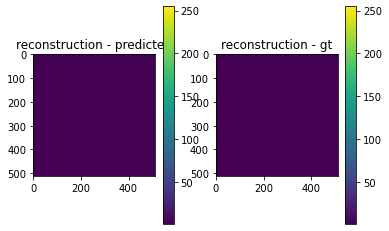

In [9]:
plot_model_progress(model, geometry.reflect_fill_sinos(*geometry.zero_cropp_sinos(SINO_DATA, ar, 0)), SINO_DATA, PHANTOM_DATA)

In [7]:
recons = geometry.fbp_reconstruct(SINO_DATA)
print(torch.mean((recons-PHANTOM_DATA)**2).item())

0.005315318074442698


In [10]:
modelname = "afbp_draft1.0"
from models.modelbase import save_model_checkpoint
save_path = GIT_ROOT / "data" / "models" / (modelname + ".pt")
save_model_checkpoint(model, optimizer, loss, save_path, "FlatFanBeam", ar)
print("model saved to", save_path)

model saved to /home/emastr/deep-limited-angle/KEX---CT-reconstruction/data/models/afbp_draft1.0.pt
